RFM, Yenilik(Recency), Sıklık(Frequency) ve Parasal Değer(Monetary) anlamına gelir.


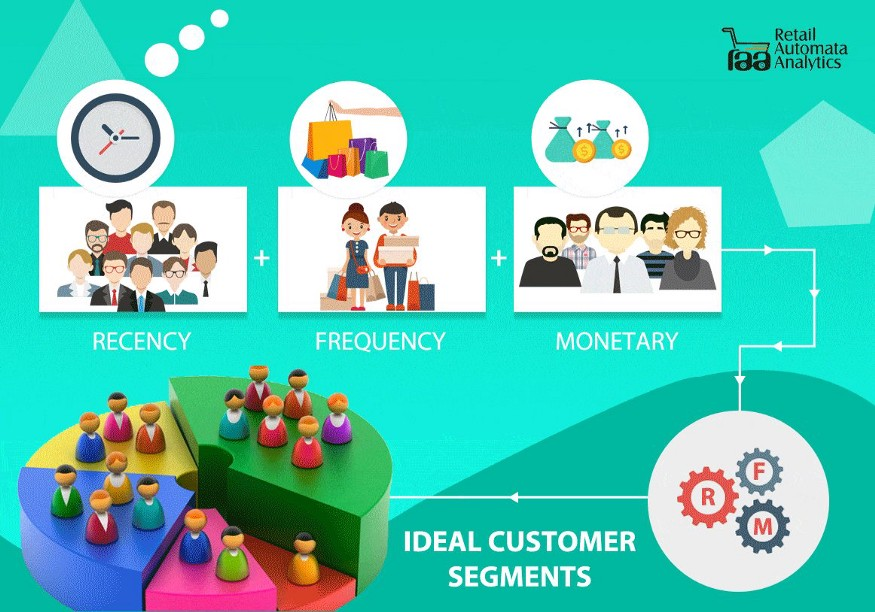

Yenilik(Recency), bir müşterinin mağazanızdan ne kadar yakın zamanda satın alma işlemi gerçekleştirdiği bilgisini verir.

Sıklık(Frequency), bir müşterinin sizden ne sıklıkla satın alma yaptığı ile ilgili değerdir.

Parasal Değer(Monetary), bir müşterinin mağazanızda harcadığı para miktarı anlamına gelir.

Bu üç parametre ile birlikte, müşteri bazlı segmentasyon yapabiliriz. Örneğin;

*-en sadık müşteriniz kim?*

*-hangi müşterilerinizi kaybetmek üzeresiniz?*

*-kampanyanıza yanıt verme olasılığı en yüksek müşteri grubu hangisi?*

Şimdi elimizde bulunan veri setiyle RFM’in nasıl analiz edildiğini ve müşterilerin nasıl segmentlere ayrıldığını inceleyelim.

**Veri seti hikayesi:**

Online Retail II isimli veri seti İngiltere merkezli online bir satış mağazasının 01/12/2009–09/12/2011 tarihleri arasındaki satışlarını içeriyor.

**InvoiceNo:** Fatura numarası. Her işleme yani faturaya ait eşsiz numara. Eğer bu kod C ile başlıyorsa işlemin iptal edildiğini ifade eder.

**StockCode:** Ürün kodu. Her bir ürün için eşsiz numara.

**Description:** Ürün ismi.

**Quantity:** Ürün adedi. Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.

**InvoiceDate:** Fatura tarihi ve zamanı.

**UnitPrice:** Ürün fiyatı (Sterlin cinsinden).

**CustomerID**: Eşsiz müşteri numarası.

**Country:** Ülke ismi. Müşterinin yaşadığı ülke.

Biz proje kapsamında online_retail_II.xlsx veri setinin “Year 2010–2011” isimli sheet’i ile analiz yapıyoruz. Burada veri setini okutup df değişkenine atadık (df_ değişkeniyle de işlemlere devam edilebilir, ancak copy() işlemi yapıp yeni bir değişkene atamak ilerleyen süreçler için daha sağlıklı olacaktır).


In [ ]:
pip install openpyxl

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

df_ = pd.read_excel("../input/online-retail-ii-data-set-from-ml-repository/online_retail_II.xlsx", sheet_name="Year 2010-2011",engine='openpyxl')

df=df_.copy()
df.head()

In [ ]:
#essiz urun sayisi:
df["Description"].nunique()

# hangi urunden kacar tane:
df["Description"].value_counts().head()

# en cok siparis edilen urun:
df.groupby("Description").agg({"Quantity": "sum"}).head()

# yukarıdaki çıktıyı nasil siralariz?
df.groupby("Description").agg({"Quantity": "sum"}).sort_values("Quantity", ascending=False).head()

# toplam kac fatura kesilmiştir?
df["Invoice"].nunique()

# fatura basina ortalama kac para kazanilmistir? ,
# (iki değişkeni çarparak yeni bir değişken oluşturmak gerekmektedir)
# iadeleri çıkararak yeniden df'i oluşturalım
df= df[~df["Invoice"].str.contains("C", na=False)] #iadeleri çıkardık

df["TotalPrice"] = df["Quantity"] * df["Price"]

#en pahali urunler:
df.sort_values("Price",ascending=False).head()

# hangi ulkeden kac siparis geldi?
df["Country"].value_counts()

# hangi ulke ne kadar kazandırdı?
df.groupby("Country").agg({"TotalPrice":"sum"}).sort_values("TotalPrice",ascending=False).head()

df.isnull().sum()
df.dropna(inplace=True)

df.describe([0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).T


today_date, son alışveriş yapılan tarihten iki gün sonra olarak tanımlandı.

Recency değerine bugünün tarihinden en son satın alma tarihini çıkararak erişmiş olduk. Customer ID değeri ile yaptığımız groupby işlemi sonucunda Recency, Frequency, Monetary değerlerini elde etmiş olduk ve bunları isimlendirdik.

In [ ]:
#RFM Calculating
import datetime as dt

df["InvoiceDate"].max() # veri setindeki max tarih Timestamp('2011-12-09 12:50:00')
today_date = dt.datetime(2011, 12, 11)

rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                     'Invoice': lambda num: len(num),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

rfm.columns= ['Recency', 'Frequency', 'Monetary']

rfm = rfm[(rfm["Monetary"]) > 0 & (rfm["Frequency"] > 0)] #iki tane monetory sıfır değer vardı
rfm

Segmentlere ayırma aşamasında ise, qcut fonksiyonunu kullandık. Bu sayede Recency, Frequency ve Monetary tablosu altında bulunan tüm değerler 5 ayrı gruba ayrılmış oldu.

RFM_SCORE isimli bir değişken oluşturarak bulduğumuz değerleri birleştirdik. Birleştirme işleminin gerçekleşmesi için, elimizdeki değerleri astype(str) ile string’e çevirdik.

In [ ]:
#rfm scores

rfm["RecencyScore"]= pd.qcut(rfm['Recency'],5,labels=[5, 4, 3, 2, 1]) #qcut küçükten büyüğe sıralar

rfm

rfm["FrequencyScore"] = pd.qcut(rfm['Frequency'], 5, labels=[1, 2, 3, 4, 5])

rfm["MonetaryScore"] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm["RFM_SCORE"] = (rfm['RecencyScore'].astype(str) +
                    rfm['FrequencyScore'].astype(str) +
                    rfm['MonetaryScore'].astype(str))

rfm[rfm["RFM_SCORE"] == "555"].head()

In [ ]:
# RFM isimlendirmesi
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At_Risk',
    r'[1-2]5': 'Cant_Loose',
    r'3[1-2]': 'About_to_Sleep',
    r'33': 'Need_Attention',
    r'[3-4][4-5]': 'Loyal_Customers',
    r'41': 'Promising',
    r'51': 'New_Customers',
    r'[4-5][2-3]': 'Potential_Loyalists',
    r'5[4-5]': 'Champions'
}

rfm

rfm['Segment'] = rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)

Bu aşamadan sonra Recency, Frequency, Monetary değerlerinin mean ve count bilgilerini de görüntüleyebiliriz.

In [ ]:
rfm[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg(["mean", "count"])